## Part II: Exploratory data analysis of the drug reviews

#### In this section, we will emphasize the exploratory data analysis of the review text exclusively, considering the uniqueness of the text data.

In [89]:
import re
import nltk
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import altair as alt

In [90]:
df=pd.read_csv('data/df_new.csv', index_col=0)
df.head(3)

drugName                     condition  \
163740  Mirtazapine                    Depression   
206473   Mesalamine  Crohn's Disease, Maintenance   
159672      Bactrim       Urinary Tract Infection   

                                                   review  rating        date  \
163740  "I&#039;ve tried a few antidepressants over th...    10.0  2012-02-28   
206473  "My son has Crohn&#039;s disease and has done ...     8.0  2009-05-17   
159672                      "Quick reduction of symptoms"     9.0  2017-09-29   

        usefulCount  year  month  weekday  
163740           22  2012      2        1  
206473           17  2009      5        6  
159672            3  2017      9        4

There are several ways to remove html tags:
1. we can define the function by ourselves like:
def remove_html_tags(raw_text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', raw_text)
    
2. use lxml from BeautifulSoup:
from bs4 import BeautifulSoup
clean_text = BeautifulSoup(raw_text, "lxml").text

3. use html.sparser from BeautifulSoup
clean_text = BeautifulSoup(raw_text, 'html.parser').get_text()

Here we choose html.parser, the default method in BeautifulSoup. We didn't use stemmer for wordcloud analysis because the words after stemmerization will be difficult to understand.

**Q:**
<span style='color:Blue'>Which stopword list should we use for our analysis?</span>

<span style='color:Blue'>There are two most widely used stopword list, the one from wordcloud and the other one from nltk.corpus. However, both of them include less than 200 english words. We want to find a more comprehensive one. Google help us find a good stopword set from the IR Multilingual Resources at UniNE (University of Neuchâtel, Switzerland). Their English stop word list includes 571 words, so it's worthwhile to give it a try and compare it with the other widely used stopwords</span>

In [91]:
#find a proper stop words list for the analysis
import requests
url = 'http://members.unine.ch/jacques.savoy/clef/englishST.txt'
r = requests.get(url)
with open('./data/englishST.txt', 'wb') as f:
    f.write(r.content)

In [92]:
stop_words = []
with open('data/englishST.txt', 'r') as f:
    [stop_words.append(word) for line in f for word in line.split()]
stopwords_1=set(stop_words)
len(stopwords_1)

570

In [93]:
#let's check the length of STOPWORDS from wordcloud
from wordcloud import STOPWORDS
stopwords_2=set(STOPWORDS)
len(stopwords_2)

192

In [94]:
#Let's check the length of the classic NLTK stopwords
from nltk.corpus import stopwords
stopwords_3=set(stopwords.words('english'))
len(stopwords_3)

179

In [95]:
#This part is revised based on the code from https://github.com/k2973363.
from nltk.stem.wordnet import WordNetLemmatizer #We didn't use stemmer here because we found it's hard to understand the review after stemmeration.
lemmatizer = WordNetLemmatizer() #Thus we use lemmatizer instead.
def clean_review(review):
    review_text = BeautifulSoup(review, 'html.parser').get_text() #remove html tags
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text) #substitute all non-letter symbols with space
    words = letters_only.lower().split() #convert all element in the string into lower case
    useful_w=[w for w in words if not w in stopwords_1] #remove the most common stop words
    lemma_w = [lemmatizer.lemmatize(w, 'v') for w in useful_w] #lemmatize the text
    return( ' '.join(lemma_w)) #join the stemming_words use space

In [96]:
#test the function using individual review in the data
df.review[0]

'"Been on the depo injection since January 2015, had bleeding but it stopped after a while. When I had another injection in June, I didn&#039;t bleed for about a month. Started spotting mid-July and since approx. August 1st, I have been bleeding constantly, heavy enough to use pads and now it&#039;s almost November! I&#039;m sick of bleeding and forking out money for sanitary pads when I shouldn&#039;t be bleeding-well not as long as I have been now! Currently awaiting an ultrasound to see what is happening. I would like to change my contraceptive but my doctor won&#039;t let me :("'

In [97]:
clean_review(df.review[0])

'depo injection january bleed stop injection june didn bleed month start spot mid july approx august st bleed constantly heavy pad november sick bleed fork money sanitary pad shouldn bleed long await ultrasound happen change contraceptive doctor win'

In [98]:
df['clean_re']=[clean_review(i) for i in df.review]
df.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'year', 'month', 'weekday', 'clean_re'],
      dtype='object')

### 2.1 word cloud analysis

**Q:**
<span style='color:Blue'>What's the most frequent meaninful words in these reviews? Can we catch a glimpse of their content using wordcloud plot?</span>

<span style='color:Blue'>Because these reviews cover totally 708 condition and some condition only has several reviews, we choose the top three most reviewed conditions for our analysis. They are pain, depression, and birth control. We will explore both single wordcloud and bigram, even trigram wordcloud. Let's check what the reviewers talk about those drugs, their efficacy and side effect based on wordcloud analysis.</span>

In [99]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
def wordCloud_word(review, mask=None, stopwords=None):
    text=" ".join(r for r in review)
    wordcloud = WordCloud(background_color = 'white', max_font_size=80, max_words=100, mask=mask, stopwords = stopwords, width = 1200, height = 800).generate(text)
    plt.figure()
    plt.rcParams['figure.figsize'] = (14, 14)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [100]:
#revised based on the code from https://stackoverflow.com/questions/49537474/wordcloud-of-bigram-using-python
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
def clean_review_ngram(review):
    text = BeautifulSoup(review, 'html.parser').get_text() #remove html tags
    text = text.lower()
    text = ''.join([i for i in text if not i.isdigit()]) #remove digits
    text = text.replace("'", "")# Remove single quote to avoid problems with the tokenizer.
    tokens = nltk.word_tokenize(text)
    text1 = nltk.Text(tokens)
    text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]#remove extra character
    text_content = [word for word in text_content if word not in stopwords_1] #remove meaningless words using stopwords_1
    text_content = [s for s in text_content if len(s) != 0] #remove extra space
    text_content = [lemmatizer.lemmatize(t) for t in text_content] #lemmatize the words, can we find other better lemmatizer?
    bigrams_list = list(nltk.bigrams(text_content))
    text_dict = [' '.join(tup) for tup in bigrams_list]
    return text_dict

In [101]:
#count the frequency of ngrams in reviews and generate a wordcloud
from sklearn.feature_extraction.text import CountVectorizer
def wordCloud_ngram(text, n, m, mask=None):# n is the number of grams, m is the number of max_words
    vectorizer = CountVectorizer(ngram_range=(n, n))
    bag_of_words = vectorizer.fit_transform(text_dict)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq) #all above steps are used for obtaining the bigram frequency
    wordCloud = WordCloud(background_color = 'white', max_font_size=80, max_words=m, mask=mask, width = 1200, height = 800, stopwords=stopwords_1)
    wordCloud.generate_from_frequencies(words_dict)#Here we use wordcloud stopword for generating more possible bigrams.
    plt.figure()
    plt.rcParams['figure.figsize'] = (12, 12)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()  
#As for the detail of CountVectorizer, please read this article, https://medium.com/@rnbrown/more-nlp-with-sklearns-countvectorizer-add577a0b8c8

#### 2.1.1 pain killer

**Q:**
<span style='color:Blue'>Based on the reviews, can we get a general impression about those pain killer pills? Are they effective? Do people complain their side effects? What are their side effects? Which ones are the most effective? Which ones have a lot of compaint?</span>

<span style='color:Blue'>There are totally 219 different pain killers. Among them, Tramadol is the top one pain killer.</span>

In [102]:
pain=df[df.condition == 'Pain']
round(pain.drugName.value_counts()/len(pain)*100,2)

Tramadol                       6.08
Acetaminophen / hydrocodone    5.48
Oxycodone                      4.61
Acetaminophen / oxycodone      4.40
Tapentadol                     3.46
                               ... 
Oxydose                        0.01
Benzocaine                     0.01
Motrin Infant Drops            0.01
Lagesic                        0.01
Panlor DC                      0.01
Name: drugName, Length: 219, dtype: float64

In [103]:
len(set(pain.drugName))

219

In [104]:
#define a proper word cloud function using proper mask. The detail information can be found in datacamp wordcloud tutorial, https://www.datacamp.com/community/tutorials/wordcloud-python
mask = np.array(Image.open("data/70420.png"))
thumb_up_mask=255-mask
thumb_down_mask=np.fliplr(thumb_up_mask)[::-1]

In [105]:
#We found extra stop words exist in the wordcloud like year, month, day, etc
stopwords_update=stopwords_1|{'year', 'month', 'week', 'day', 'years', 'months','weeks', 'days', 'doctor', 'drug', 'medicine', 'medication'}
len(stopwords_update)

582

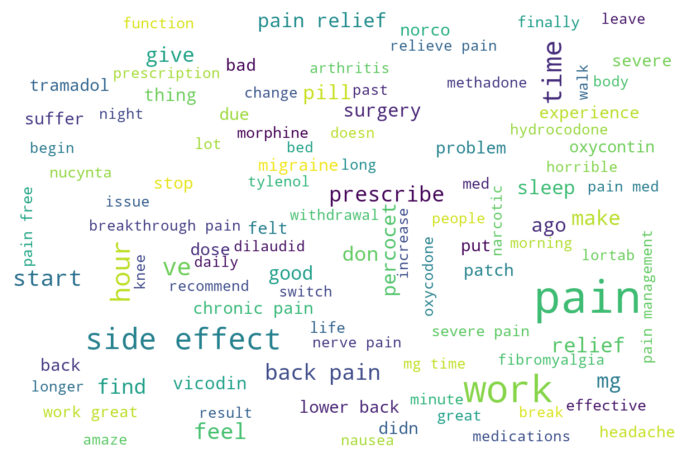

In [106]:
#word cloud for the reviews about pain killers
wordCloud_word(pain.clean_re, mask=None, stopwords=stopwords_update)

We have to admit this wordcloud is a mixed bag of words, including both positive and negative words.No doubt pain is the most significant word, including nerve pain, back pain, chronic pain, etc. It describes why people took those medicine. There are also some positive words, for example work, amaze, effective, good, etc. But there are also some negative ones, such as side effect, worse, suffer, etc. We can also notice drug names, dilaudid, tramadol, oxycontin, hydrocodone, etc. 

**Q:**
<span style='color:Blue'>What if we separate these reviews into the one with good rating and the one with bad rating? Can we extract more meaningful information from those reviews?</span>

In [107]:
#word cloud for the high rating pain killers among the top_reviewed pain killers
high_rating_pain=pain[pain.rating >= 9].clean_re
len(high_rating_pain)

4578

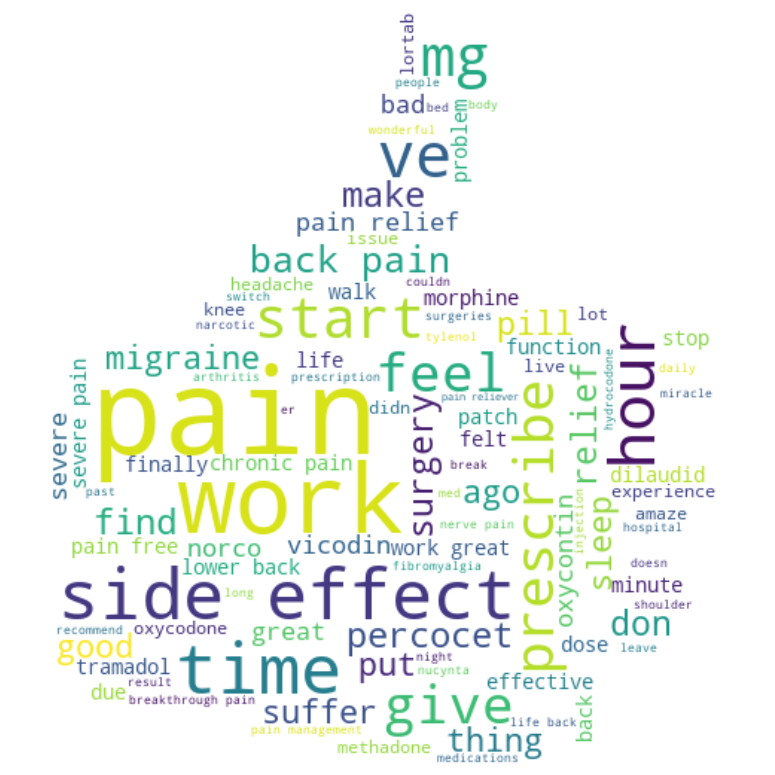

In [108]:
wordCloud_word(high_rating_pain, mask=thumb_up_mask, stopwords=stopwords_update)

Well, we still can see some negative words, like side effect, suffer, problem, etc. But we can also notice the big 'work' too. Percocet, dilaudid, oxycontin, vicondin are the drugs with big names here. Percocet is a mixed drug, with an opioid pain reliever (oxycodone) and a non-opioid pain reliever (acetaminophen). Vicondin is also a mixed one. It contains an opioid pain reliever (hydrocodone) and a non-opioid pain reliever (acetaminophen). The others are opioid pain relievers.

In [109]:
low_rating_pain=pain[pain.rating <= 2].clean_re
len(low_rating_pain)

1022

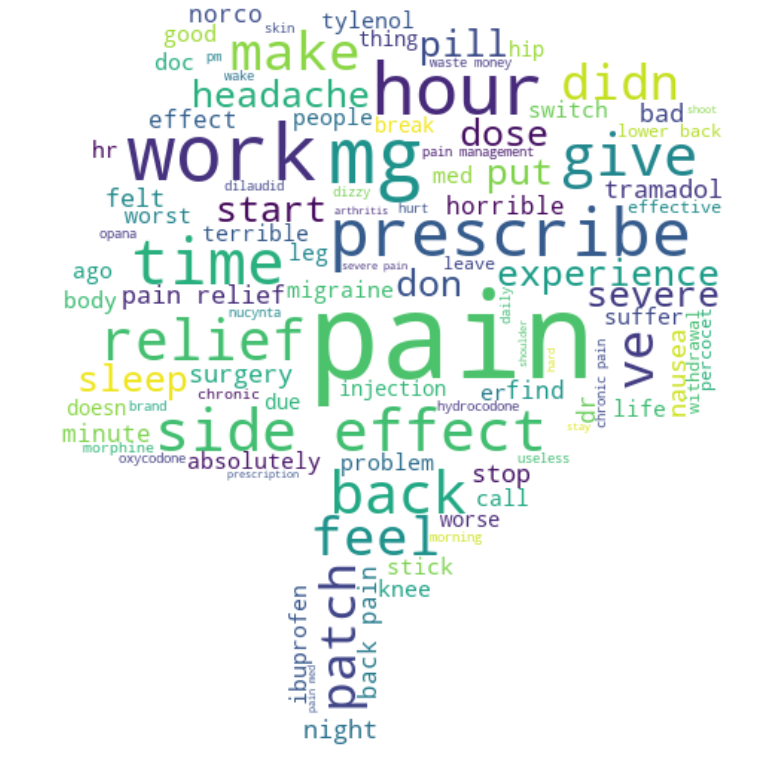

In [110]:
#word cloud for low rating pain killers among the top reviewed ones
wordCloud_word(low_rating_pain, mask=thumb_down_mask, stopwords=stopwords_update)

The data gave us similar results as the reviews with high rating. Pain, work, and side effect are still isted in the top words. But we can see more negative words now. Tramadol,oxycontin, oxycodone, hydrocodone are all listed in this wordcloud. All of them are opioid pain relievers.

**Q:**
<span style='color:Blue'>What if we draw bigram or trigram wordcloud for the pain killers? Can we get more insight?</span>

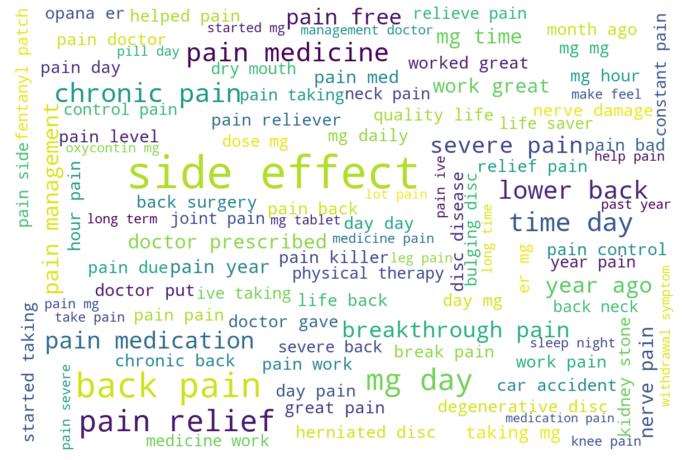

In [112]:
text=" ".join(i for i in pain.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100)

Most top bigams are related with pain if we didn't differentiate the high rating reviews and low rating reviews. 

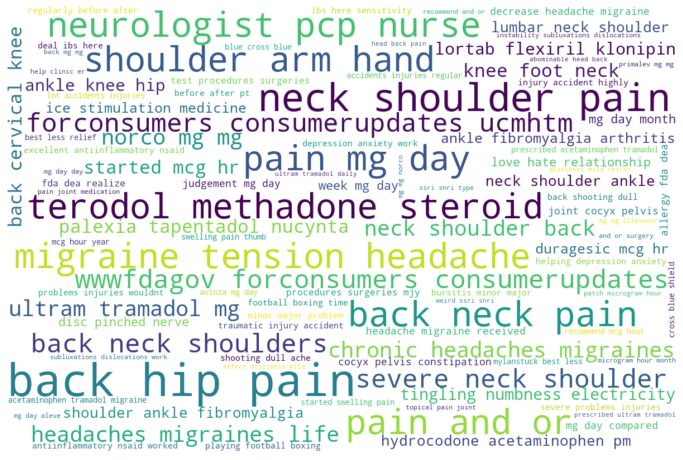

In [113]:
wordCloud_ngram(text_dict, 3, 100)

Here we can get more clear information about the effect of the drugs through bigram and trigram wordcloud than single word wordcloud. We also notice some nonsense trigrams in the word cloud.


**Q:**
<span style='color:Blue'>What if we draw the bigram and trigram wordcloud for the reviewse with good rating and the ones with bad rating separately? Can we extract more meaningful information from those reviews?</span>

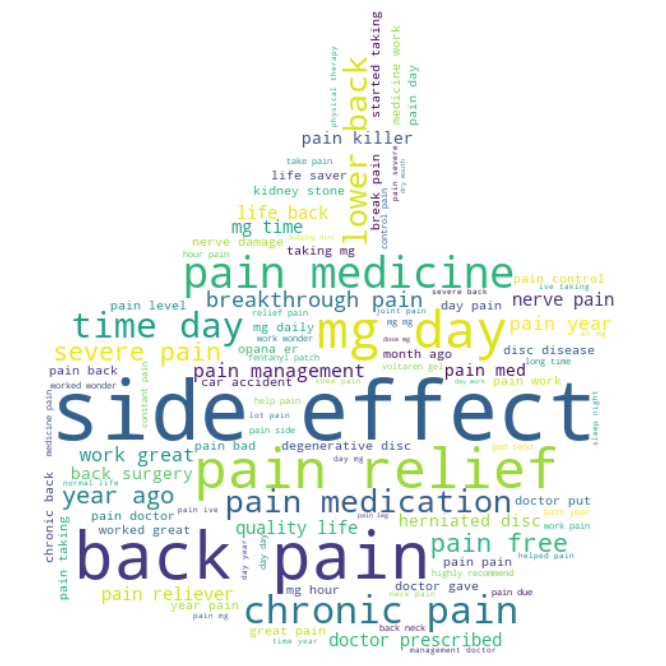

In [114]:
#reviews of the high rating pain killers
high_rating_pain=pain[pain.rating >=9]
text=" ".join(i for i in high_rating_pain.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_up_mask)

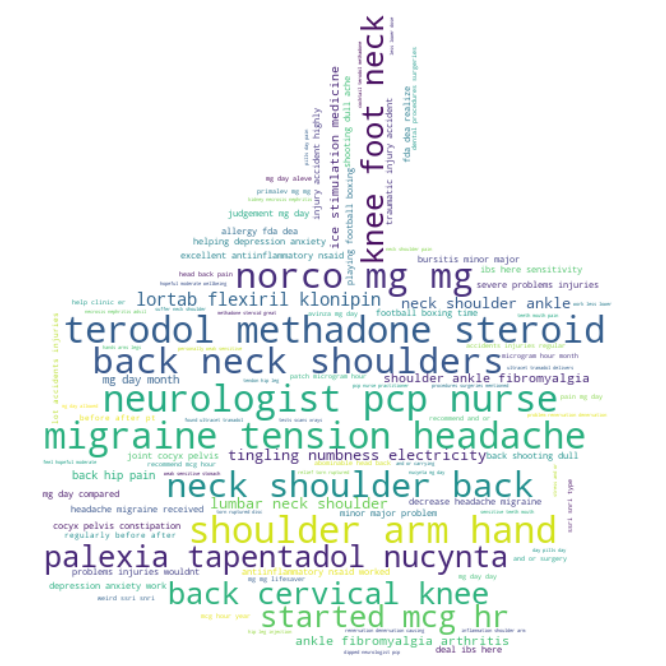

In [115]:
# It seems trigram wordcloud is not as good as the bigram wordcloud
wordCloud_ngram(text_dict, 3, 100, mask=thumb_up_mask)

The reviews with high ratings did give us more postive ngrams than the reviews with mixed one. But still there are a lot of pain related ngrams and there are some meaningless trigrams included.

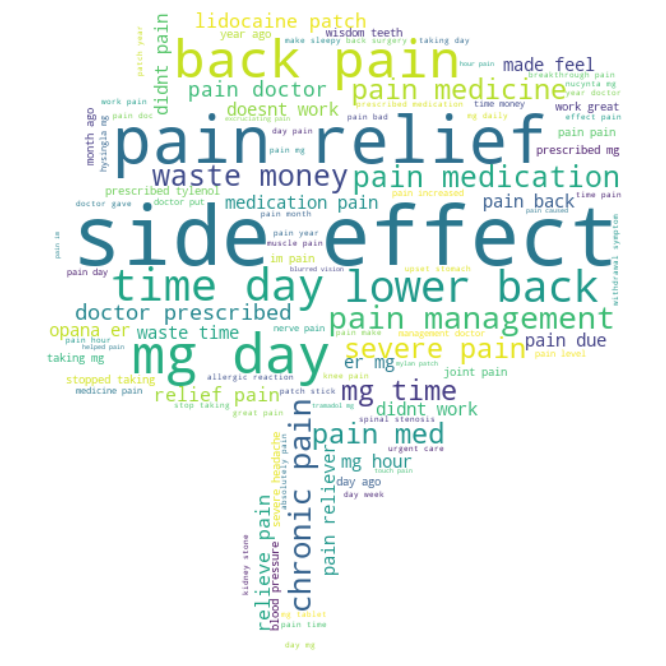

In [116]:
#reviews for the low-rating pain killers
low_rating_pain=pain[pain.rating <=2]
text=" ".join(i for i in low_rating_pain.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_down_mask)

The wordcloud using reviews with low rating gave us more clear negative response than the mixed reviews. 

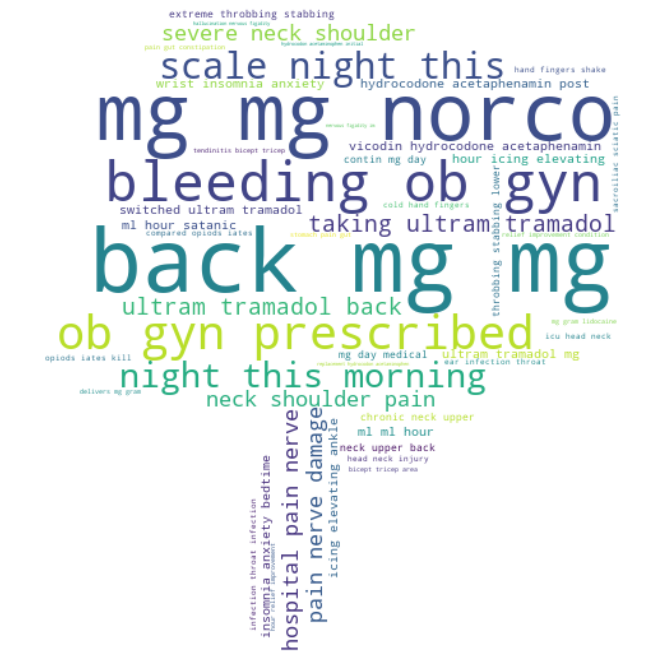

In [117]:
wordCloud_ngram(text_dict, 3, 100, mask=thumb_down_mask)
#Because of the limited trigrams, the thumb down figure didn't show very well.

Obviously, single, bigram and trigram wordcloud can give us different views of these reviews. For example, we can find drug names mentioned more frequently in single word cloud, but not in bigram and trigram. However, bigram and trigram can give us more detailed syndrome description compared with single word cloud. Let's continue to check depression and birth control reviews. 

#### 2.1.2 depression

**Q:**
<span style='color:Blue'>Based on the reviews, can we get a general impression about those antidepressants? Are they effective? Do people complain their side effects? What are their side effects? Which ones are the most effective? Which ones have a lot of compaint?</span>

In [118]:
depress=df[df.condition == 'Depression']
round(depress.drugName.value_counts()/len(depress)*100,2)

Bupropion           6.14
Sertraline          5.45
Venlafaxine         4.72
Desvenlafaxine      4.71
Pristiq             4.55
                    ... 
Abilify Discmelt    0.01
Prozac Weekly       0.01
Xanax XR            0.01
Risperdal M-Tab     0.01
Vivactil            0.01
Name: drugName, Length: 115, dtype: float64

In [119]:
len(set(depress.drugName))

115

There are totally 115 antidepressant listed in this dataset. The top 5 most reviewed ones are Sertraline, Bupropion, Desvenlafaxine, Venlafaxine and Pristiq. All of them are the second generation antidepressants. They are either Selective serotonin re-uptake inhibitors (SSRIs) or Selective serotonin noradrenaline re-uptake inhibitors (SNRIs).

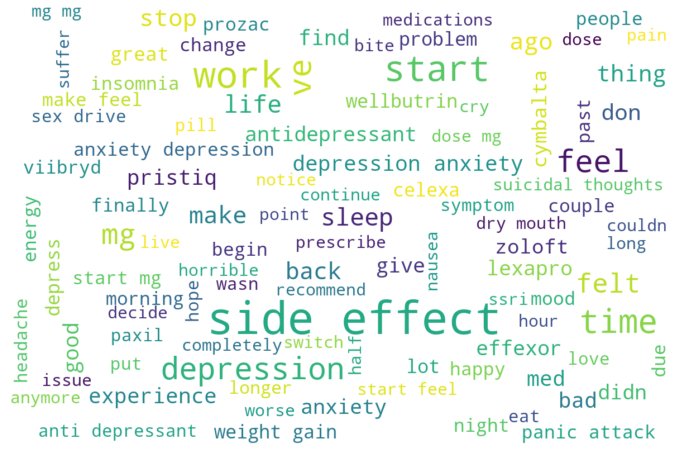

In [120]:
#word cloud for top_10_most_reviewed antidepressant
wordCloud_word(depress.clean_re, mask=None, stopwords=stopwords_update)

1. We got a wordcloud with similar size of 'work' and 'side effect'. 
2. Some positive words appeared in this plot like good, happy, great, positive etc. But there are also some negative ones, like worse, bad, tire, nausea, etc.
3. We also find some drug names, for instance, prozac, pristiq, zoloft, etc. 
4. Based on [InformedHealth.org](https://www.ncbi.nlm.nih.gov/books/NBK361016/), Over half of all people who take antidepressants have side effects. Thus, it is also reasonable for us to get such a mixed wordcloud

  Let's subset the depression review, and check the drugs with high rating reviews and the ones with low rating reviews individually.

In [121]:
#word cloud for high rating antidepression drugs
high_rating_depress=depress[depress.rating >= 9]
len(high_rating_depress)

5779

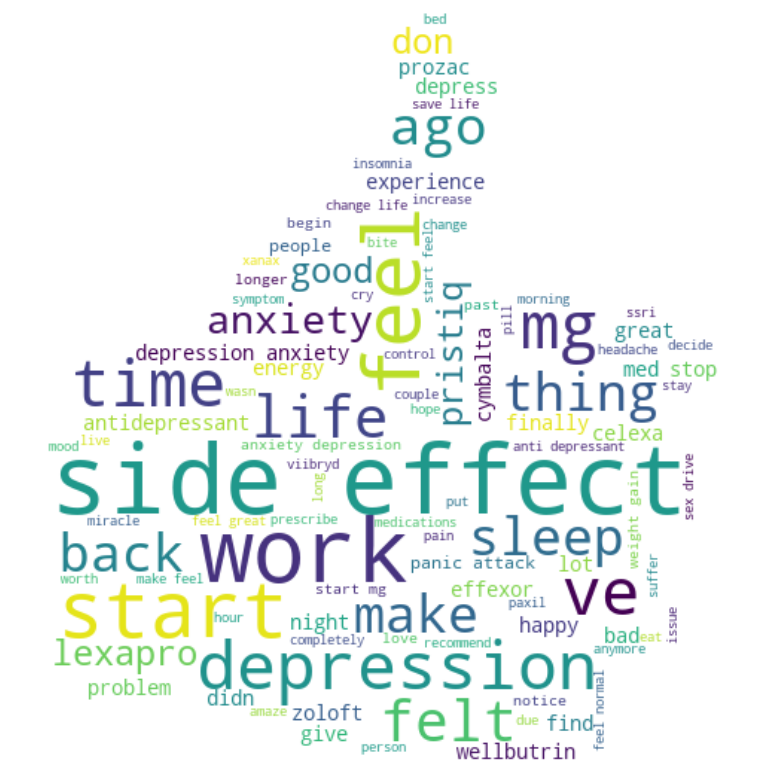

In [122]:
wordCloud_word(high_rating_depress.clean_re, mask=thumb_up_mask, stopwords=stopwords_update)

We still got a mixed wordcloud with similar word size of 'side effect' and 'work'.  Almost all of these drugs in this wordcloud are belong to [the second generation of antidepressant](https://www.ncbi.nlm.nih.gov/books/NBK361016/), except wellbutrin.

In [123]:
#word cloud for low rating drug
low_rating_depress=depress[depress.rating <= 2]
len(low_rating_depress)

1884

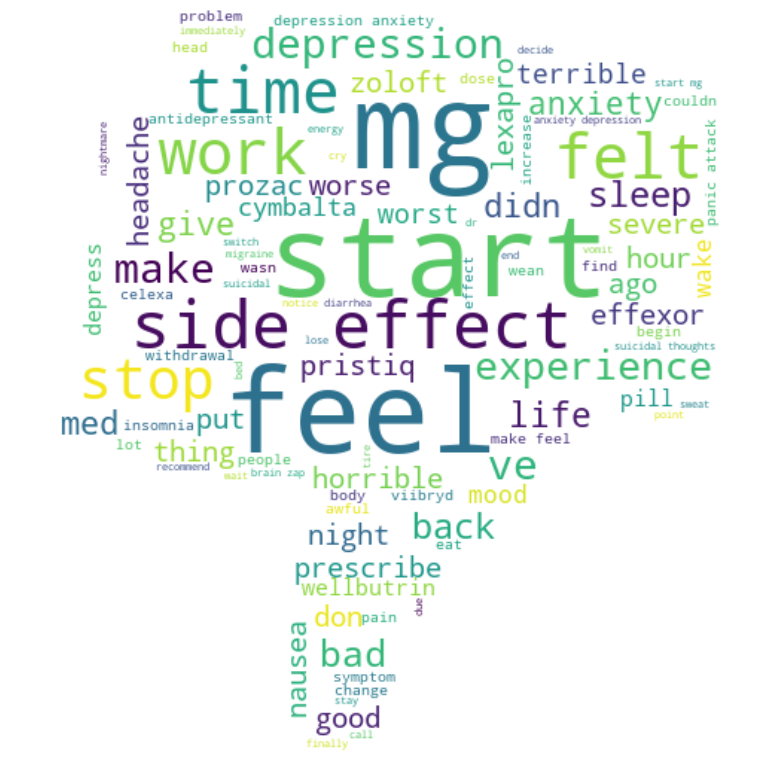

In [124]:
wordCloud_word(low_rating_depress.clean_re, mask=thumb_down_mask, stopwords=stopwords_update)

lexapro, cymbalta, zoloft, celexa, effexor, pristiq are all listed as the drugs with low rating reviews. Among them, Cymbalta, lexapro, zoloft, pristiq are also listed as high rating drugs in some reviews. Thus, we got mixed opinions. But there are more than 3 times more postive reviews than the negative ones. There are a lot of negative words included in this wordcloud plot, for example, worst, insomnia, depress, worse, problem, bad, pain, terrible, etc. Because most drugs listed in the wordcloud are the second generation antidepressant, it indicates the second generation antidepressant are the most widely used one now.

**Q:**
<span style='color:Blue'>Can we get more information from bigram and trigram wordcloud?</span>

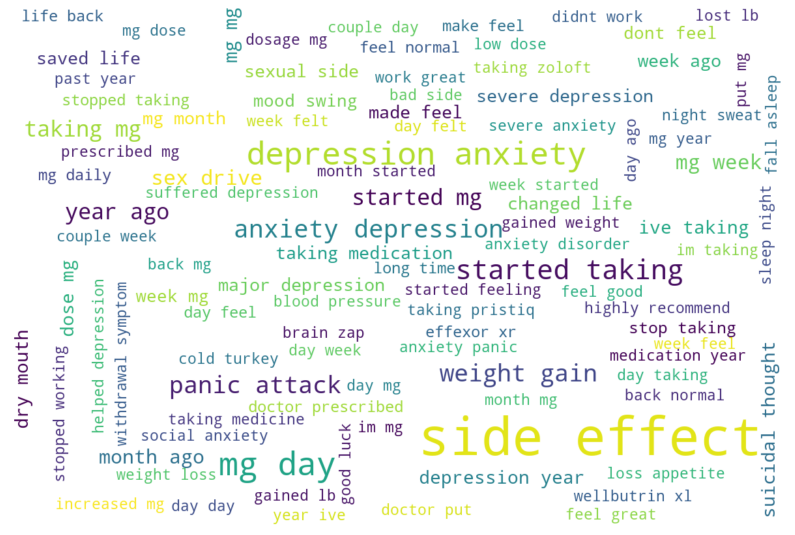

In [125]:
text=" ".join(i for i in depress.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100)

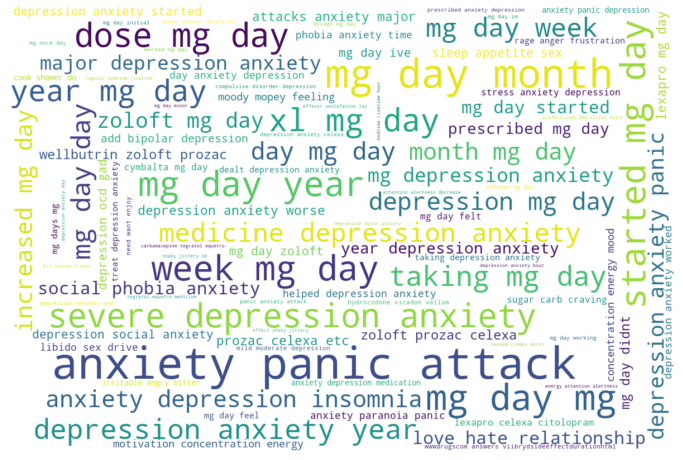

In [126]:
wordCloud_ngram(text_dict, 3, 100)

There are more detailed syndrome description give in bigram and trigram. Still there are meaningless trigrams included in the wordcloud.

**Q:**
<span style='color:Blue'>Can we get more clear information from bigram or trigram wordcloud by analyzing the reviews with high ratings and low ratings separately?</span>

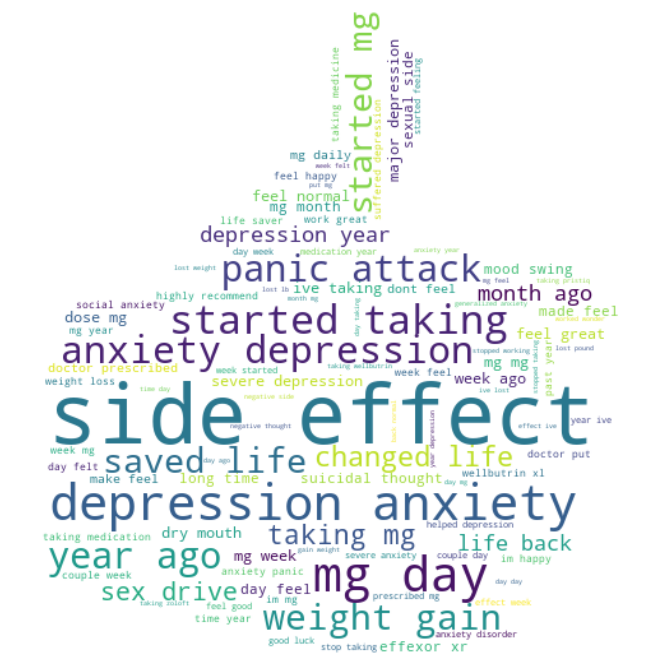

In [127]:
#high rating antidepressants
text=" ".join(i for i in high_rating_depress.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_up_mask)

We can see more positive words now although tere is still negative word like panic attack, suicidal thought, etc.

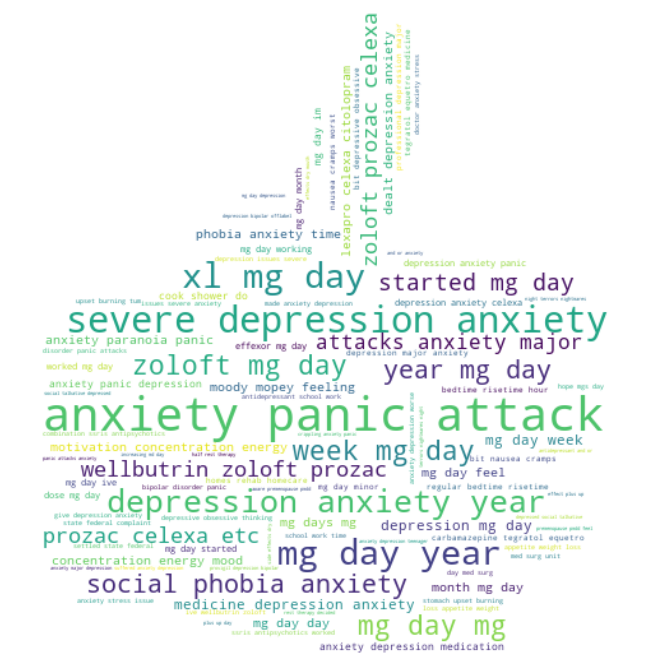

In [128]:
wordCloud_ngram(text_dict, 3, 100, mask=thumb_up_mask)

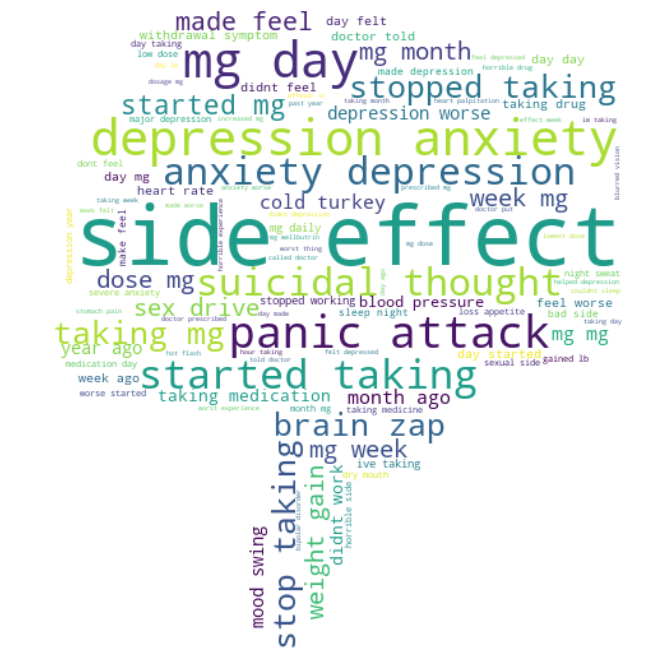

In [129]:
#low rating antidepressants
text=" ".join(i for i in low_rating_depress.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_down_mask)

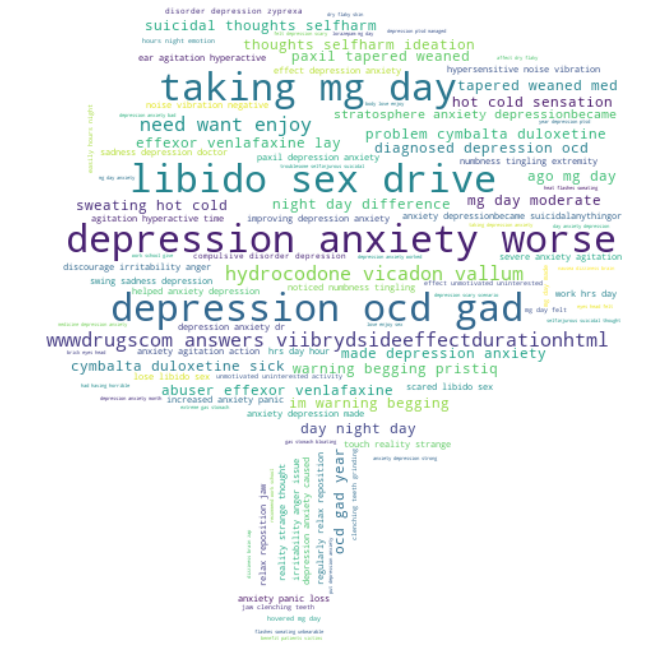

In [130]:
wordCloud_ngram(text_dict, 3, 100, mask=thumb_down_mask)

Compared with highly-rated reviews, low-rated reviews have more negative words and their sizes are also bigger. For instance, suicidal thought, panic attack, and side effect.

#### 2.1.3 birth control

**Q:**
<span style='color:Blue'>Based on the birth control drug reviews, can we extract some general information, their efficacy, their side effect, etc? </span>

In [131]:
birth_control=df[df.condition == 'Birth Control']
round(birth_control.drugName.value_counts()/len(birth_control)*100,2)

Etonogestrel                          11.43
Ethinyl estradiol / norethindrone      8.02
Levonorgestrel                         7.50
Nexplanon                              7.50
Ethinyl estradiol / levonorgestrel     5.48
                                      ...  
Pirmella 1 / 35                        0.00
Larin 24 Fe                            0.00
Larissia                               0.00
Philith                                0.00
Loestrin 21 1.5 / 30                   0.00
Name: drugName, Length: 181, dtype: float64

In [132]:
len(set(birth_control.drugName))

181

There are totally 181 birth control drugs reviewed in this data set. Amont these top 5 birth control drugs, Etonogestrel and Levonorgestrel are Progestogen, the other are estrogen. All of them are hormone related birth control drugs. As for the details about these drugs, please check this website, https://medlineplus.gov/druginfo/meds/a601050.html

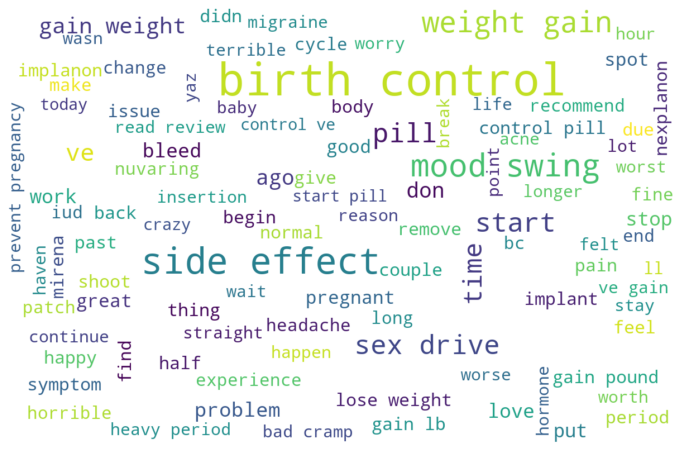

In [133]:
wordCloud_word(birth_control.clean_re, mask=None, stopwords=stopwords_update)

Without distinguishing the high rating and low rating reviews, there are mixed positive and negative words for birth control drug reviews. They have obvious side effect, such as modd swing, bleed. Generally there are more negavie words than the positive ones.

In [134]:
high_rating_birthcontrol=birth_control[birth_control.rating >= 9]
len(high_rating_birthcontrol)

13451

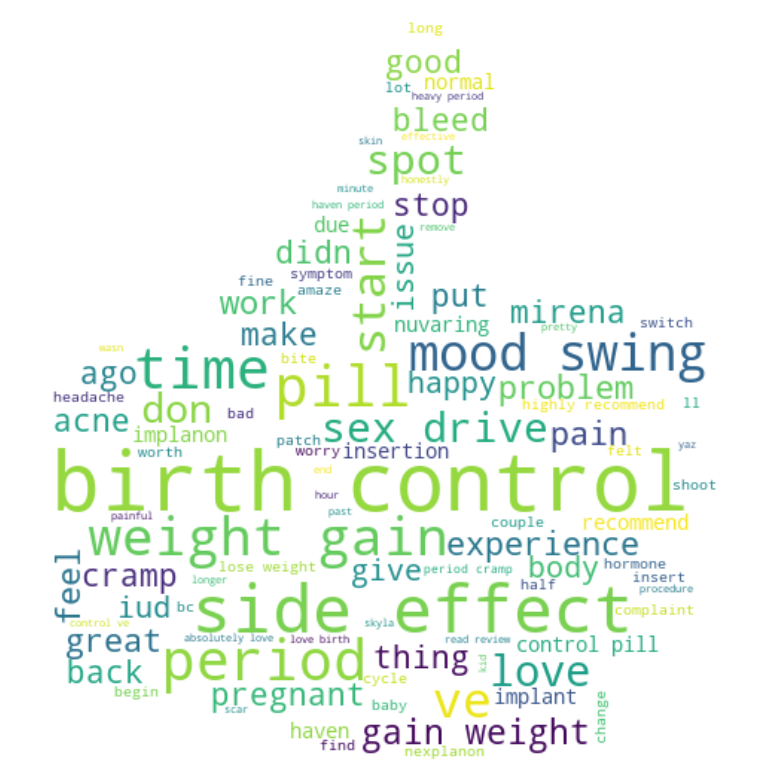

In [135]:
wordCloud_word(high_rating_birthcontrol.clean_re, mask=thumb_up_mask, stopwords=stopwords_update)

We can get more positive words once we only analyzing the high rating reviews

In [136]:
low_rating_birthcontrol=birth_control[birth_control.rating <= 2]
len(low_rating_birthcontrol)

8663

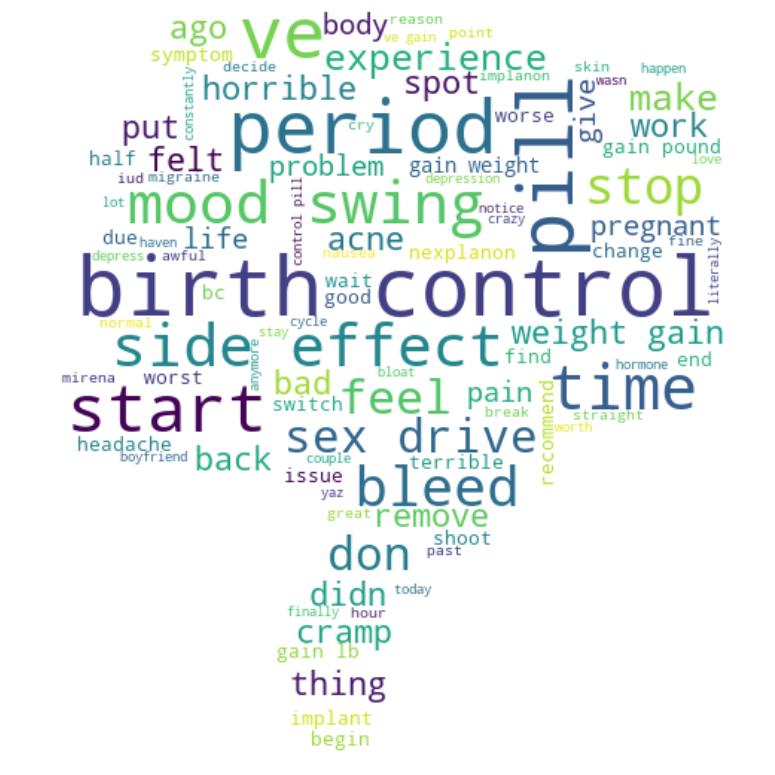

In [137]:
wordCloud_word(low_rating_birthcontrol.clean_re, mask=thumb_down_mask, stopwords=stopwords_update)

We also can get more negaive if we analyze the low rating reviews only.


**Q:**
<span style='color:Blue'>Can we get more information from bigram and trigram wordcloud? </span>

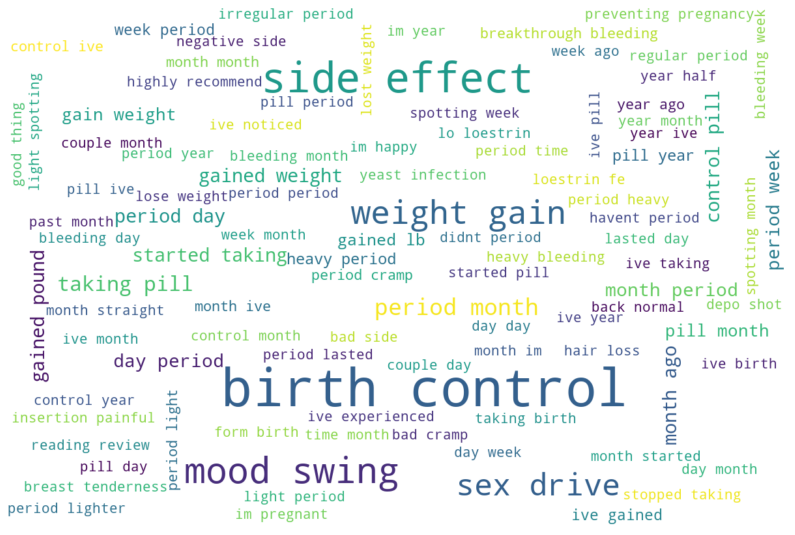

In [138]:
#bigram and trigram birth_control
text=" ".join(i for i in birth_control.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100)

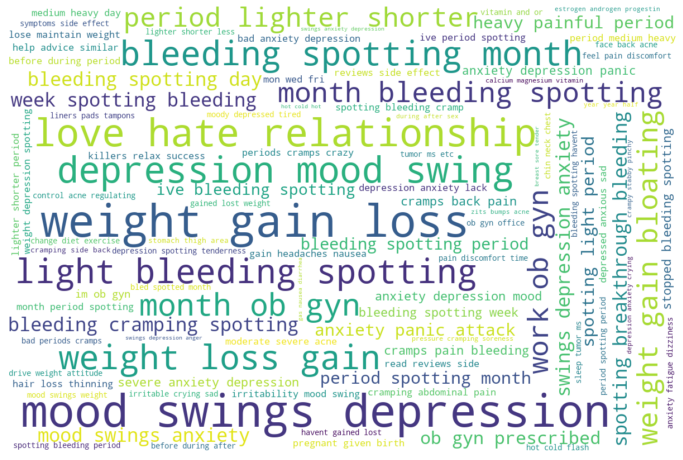

In [139]:
wordCloud_ngram(text_dict, 3, 100)

**Q:**
<span style='color:Blue'>Can we get more information from bigram and trigram wordcloud after dividing the reviews into high rating group and low rating group? </span>

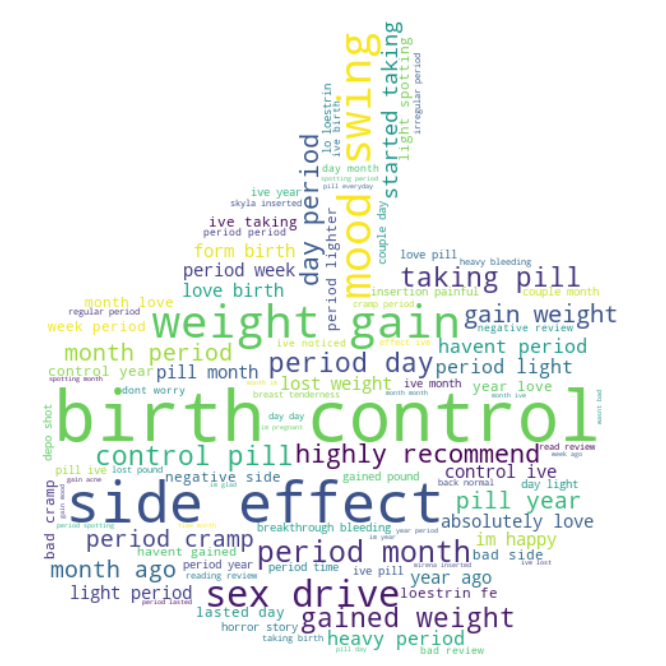

In [140]:
#high rating birth control pills
text=" ".join(i for i in high_rating_birthcontrol.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_up_mask)

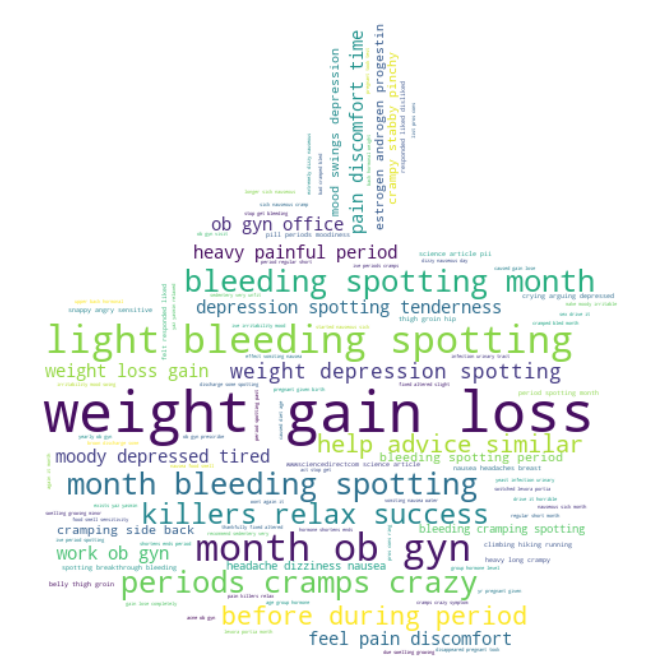

In [141]:
wordCloud_ngram(text_dict, 3, 100, mask=thumb_up_mask)

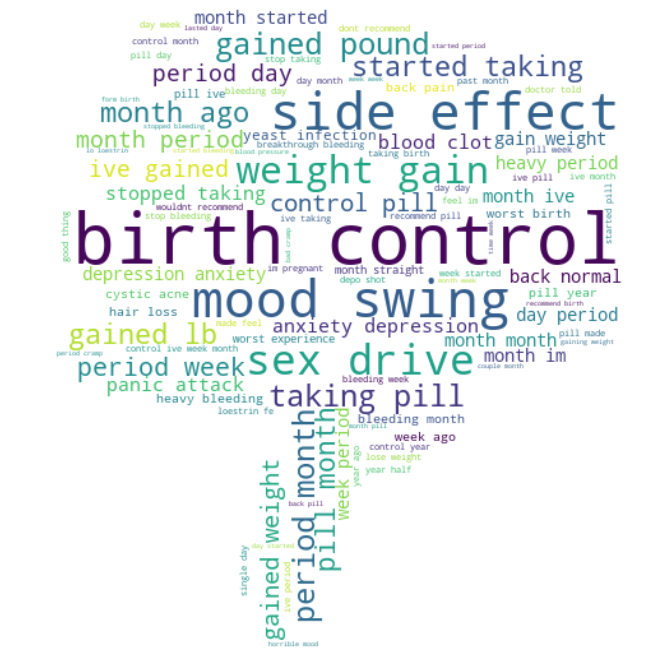

In [142]:
#low rating birth control pills
text=" ".join(i for i in low_rating_birthcontrol.review)
text_dict=clean_review_ngram(text)
wordCloud_ngram(text_dict, 2, 100, mask=thumb_down_mask)

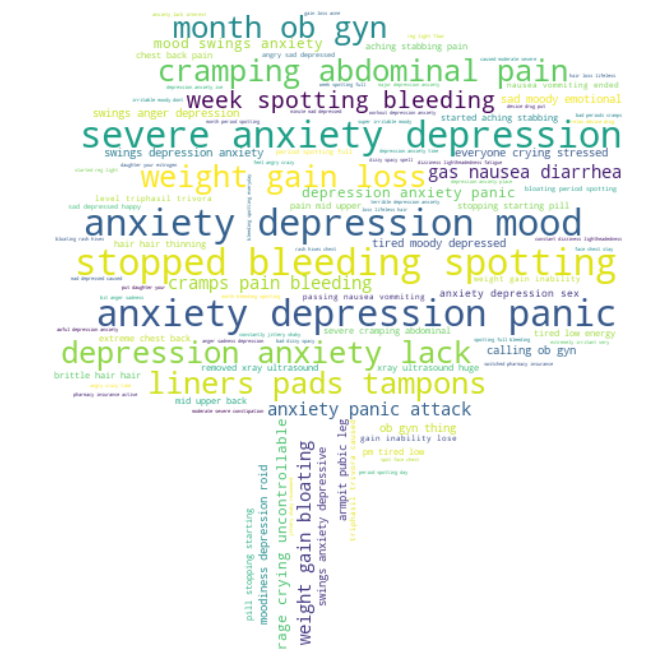

In [143]:
wordCloud_ngram(text_dict, 3, 100, mask=thumb_down_mask)

Similar to reviews from depression and pain, differentiating the reviews based on rating can give us more detailed positive and negative ngrams, but it can not make the wordCloud perfectly positive or negative word clusters. Bigram and trigram wordcloud can give us more detailed syndrome descriptions than the single word cloud.

### 2.2 review length distribution across time, condition, rating and usefulCount

In [144]:
#It is used to evaluate the length of the review by the number of sentences
def review_sent_len(review):
    review_text = BeautifulSoup(review, 'html.parser').get_text()
    s=nltk.sent_tokenize(review)
    return len(s)
df['sent_len']=[review_sent_len(r) for r in df.review]

In [145]:
#We can also use the number of words in the review to assess the length of the review
def review_word_len(review):
    text = BeautifulSoup(review, 'html.parser').get_text()
    text = text.lower()
    text = ''.join([i for i in text if not i.isdigit()]) #remove digits
    text = text.replace("'", "")# Remove single quote to avoid problems with the tokenizer.
    w=nltk.word_tokenize(text)
    return len(w)
df['word_len']=[review_word_len(r) for r in df.review]

In [146]:
df.head()

drugName                     condition  \
163740      Mirtazapine                    Depression   
206473       Mesalamine  Crohn's Disease, Maintenance   
159672          Bactrim       Urinary Tract Infection   
39293          Contrave                   Weight Loss   
97768   Cyclafem 1 / 35                 Birth Control   

                                                   review  rating        date  \
163740  "I&#039;ve tried a few antidepressants over th...    10.0  2012-02-28   
206473  "My son has Crohn&#039;s disease and has done ...     8.0  2009-05-17   
159672                      "Quick reduction of symptoms"     9.0  2017-09-29   
39293   "Contrave combines drugs that were used for al...     9.0  2017-03-05   
97768   "I have been on this birth control for one cyc...     9.0  2015-10-22   

        usefulCount  year  month  weekday  \
163740           22  2012      2        1   
206473           17  2009      5        6   
159672            3  2017      9        4   
39293            35  2017      3        6   
97768             4  2015     10        3   

                                                 clean_re  sent_len  word_len  
163740  ve antidepressants years citalopram fluoxetine...         4        81  
206473  son crohn disease asacol complaints show side ...         4        55  
159672                           quick reduction symptoms         1         6  
39293   contrave combine drug alcohol smoke opioid ces...         8       165  
97768   birth control cycle read review type similar b...        10       157

#### 2.2.1 time dependent change of review length

**Q:**
<span style='color:Blue'>How did the length of drug reviews change from 2008 to 2017?</span>

In [147]:
# We will check the most frequence length of the reviews by the number of words and the number of sentences
def top_10_sent_len(y):
    r=(df[df.year==y].sent_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['sent_len','percentage']
    year=pd.Series([y]*10).T
    new['year']=year
    return new
def top_10_word_len(y):
    r=(df[df.year==y].word_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['word_len','percentage']
    year=pd.Series([y]*10).T
    new['year']=year
    return new

In [148]:
def top_10_sent_len_con(y, c):
    r=df[df.year==y & df['condition']==c].sent_len.value_counts().head(10)
    new=r.to_frame().reset_index()
    new.columns=['sent_len','count']
    year=pd.Series([y]*10).T
    new['year']=year
    return new
def top_10_word_len_con(y, c):
    r=df[df.year==y & df['condition']==c].word_len.value_counts().head(10)
    new=r.to_frame().reset_index()
    new.columns=['word_len','count']
    year=pd.Series([y]*10).T
    new['year']=year
    return new

In [149]:
top_sent_len_year=pd.concat([top_10_sent_len(y) for y in range(2008, 2018)], ignore_index=True)

In [150]:
top_word_len_year=pd.concat([top_10_word_len(y) for y in range(2008, 2018)], ignore_index=True)

In [151]:
#Check the change of review length by sentence during 2008 to 2017
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_sent_len_year).mark_bar().encode(
    y='percentage',
    x='sent_len'
).transform_filter(
    click
)

hist = alt.Chart(top_sent_len_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

It seems people are more and more get used to sharing experience online. Thus median and long review with number of sentence > 7 becomes more normal. Check the distribution of review length in 2008 vs 2017, we can see the apparent shift.

In [152]:
#Check the change of review length by word during 2008 to 2017
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_word_len_year).mark_bar().encode(
    y='percentage',
    x='word_len'
).transform_filter(
    click
)

hist = alt.Chart(top_word_len_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

If we check the review length evaluated by number of words, we also found these reviews can be divided into two categories from 2011 to 2014. They are either short or long. Regardless of year, thse reviews are also show bipolar syndrome. This pattern is not obvious if we use number of sentences to evaluate the review length. From 2015 to 2017, the length of reviews become more evenly distributed.

#### 2.2.2 condition dependent variance of review length

**Q:**
<span style='color:Blue'>Does different condition tend to have different length of reviews?</span>

In [153]:
def top_10_sent_len_condition(y):
    r=(df[df.condition==y].sent_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['sent_len','percentage']
    Condition=pd.Series([y]*10).T
    new['condition']=Condition
    return new
def top_10_word_len_condition(y):
    r=(df[df.condition==y].word_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['word_len','percentage']
    Condition=pd.Series([y]*10).T
    new['condition']=Condition
    return new

In [154]:
top_sent_len_condition=pd.concat([top_10_sent_len_condition(y) for y in df.condition.value_counts().head(10).index], ignore_index=True)

In [155]:
top_word_len_condition=pd.concat([top_10_word_len_condition(y) for y in df.condition.value_counts().head(10).index], ignore_index=True)

In [156]:
top_word_len_condition.head(10)

word_len  percentage      condition
0       154    1.784785  Birth Control
1       155    1.714538  Birth Control
2       156    1.613071  Birth Control
3       153    1.581850  Birth Control
4       152    1.522011  Birth Control
5       158    1.503799  Birth Control
6       150    1.495993  Birth Control
7       159    1.456967  Birth Control
8       151    1.417942  Birth Control
9       149    1.358102  Birth Control

In [157]:
#Check the change of most frequent review length by sentence across the top 10 condition
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_sent_len_condition).mark_bar().encode(
    y='percentage',
    x='sent_len'
).transform_filter(
    click
)

hist = alt.Chart(top_sent_len_condition).mark_point().encode(
    y='condition:N',
    color=alt.condition(click, 'condition:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

Well, we cannot find very big different between these top 10 conditions. How about the length of the reviews by number of words? Can they show different pattern?

In [158]:
#Check the change of review length by words across the top 10 condition
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_word_len_condition).mark_bar().encode(
    y='percentage',
    x='word_len'
).transform_filter(
    click
)

hist = alt.Chart(top_word_len_condition).mark_point().encode(
    y='condition:N',
    color=alt.condition(click, 'condition:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

length of reviews by number of words showed more diverse patterns than the length of reviews evaluated by the number of sentence.

#### 2.2.3 rating dependent variance of review length

**Q:**
<span style='color:Blue'>Do reviews with different rating tend to have different length?</span>

In [159]:
def top_10_sent_len_rating(y):
    r=(df[df.rating==y].sent_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['sent_len','percentage']
    rating=pd.Series([y]*10).T
    new['rating']=rating
    return new
def top_10_word_len_rating(y):
    r=(df[df.rating==y].word_len.value_counts(normalize=True).head(10))*100
    new=r.to_frame().reset_index()
    new.columns=['word_len','percentage']
    rating=pd.Series([y]*10).T
    new['rating']=rating
    return new

In [160]:
top_sent_len_rating=pd.concat([top_10_sent_len_rating(y) for y in range(1, 11)], ignore_index=True)
top_word_len_rating=pd.concat([top_10_word_len_rating(y) for y in range(1, 11)], ignore_index=True)

In [161]:
#Check the change of review length by sentence across rating
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_sent_len_rating).mark_bar().encode(
    y='percentage',
    x='sent_len'
).transform_filter(
    click
)

hist = alt.Chart(top_sent_len_rating).mark_point().encode(
    y='rating:Q',
    color=alt.condition(click, 'rating:Q', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

We cannot find the big difference of review length evaluated by the number of sentences between different ratings

In [162]:
#Check the change of review length by word across rating
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_word_len_rating).mark_bar().encode(
    y='percentage',
    x='word_len'
).transform_filter(
    click
)

hist = alt.Chart(top_word_len_rating).mark_point().encode(
    y='rating:Q',
    color=alt.condition(click, 'rating:Q', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

Long reviews are not necessarily high rating reviews evaluated by the number of words. 

#### 2.2.4 usefulCount dependent variance of review length


**Q:**
<span style='color:Blue'>Do review length have association with usefulCount?</span>

<AxesSubplot:xlabel='usefulCount', ylabel='sent_len'>

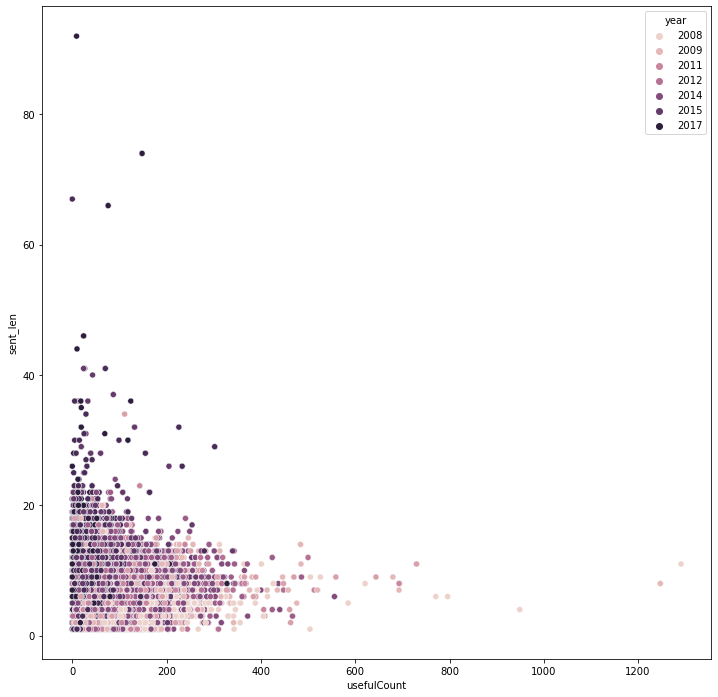

In [163]:
import seaborn as sns
sns.scatterplot(data=df, x='usefulCount', y='sent_len', hue='year')

<AxesSubplot:xlabel='usefulCount', ylabel='word_len'>

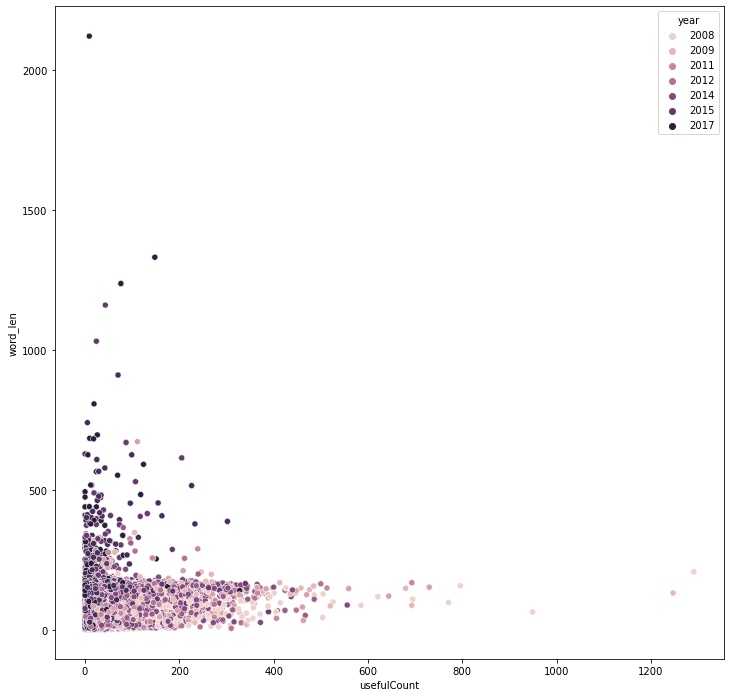

In [164]:
sns.scatterplot(data=df, x='usefulCount', y='word_len', hue='year')

We cannot find any correlation between usefulCount and review length regardless which way we use to evaluate the length.

### In summary:

1. monogram, bigram and trigram wordcloud can give us different insight of the reviews.
2. Differentiating the reviews based on rating can help us better extract information.
3. Word_len is more sensitive than sent_len as the descriptor of review length. 

In [165]:
df.to_csv('data/df_EDA.csv')